In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib.path import Path

In [3]:
from skimage.measure import find_contours

def find_contour_points(labelmap):
    '''
    return is (x,y)
    '''

    regions = regionprops(labelmap)

    contour_points = {}

    for r in regions:

        (min_row, min_col, max_row, max_col) = r.bbox

        padded = np.pad(r.filled_image, ((5,5),(5,5)), mode='constant', constant_values=0)

        contours = find_contours(padded, .5, fully_connected='high')
        contours = [cnt.astype(np.int) for cnt in contours if len(cnt) > 10]
        assert len(contours) == 1

        pts = contours[0] - (5,5)

        pts_sampled = pts[np.arange(0, pts.shape[0], 10)]

#         viz = np.zeros_like(r.filled_image)
#         viz[pts_sampled[:,0], pts_sampled[:,1]] = 1
#         plt.imshow(viz, cmap=plt.cm.gray);
#         plt.show();

        contour_points[r.label] = pts_sampled[:, ::-1] + (min_col, min_row)
        
    return contour_points

In [77]:
labelmap = np.load('/oasis/projects/nsf/csd395/yuncong/CSHL_labelMapsLossless/MD594/MD594_0154_labelMapLossless.npz')['arr_0']

In [78]:
labelmap = labelmap[::8, ::8][567:1316+1, 399:1778+1]

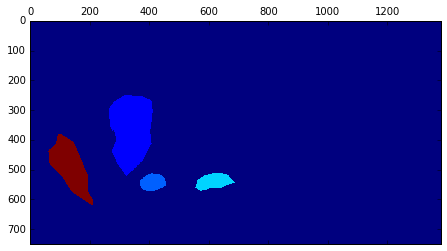

In [79]:
plt.matshow(labelmap);

In [7]:
from skimage.segmentation import find_boundaries

In [9]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']
label_dict = dict([(l,i) for i, l in enumerate(labels)])

In [11]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [12]:
score_volume_allLabels = []

for l in range(1, 10):
    volume2 = np.load(os.path.join(volume_dir, 'volume_MD594_scoreMap_%(label)d.npz'%{'label': l}))['arr_0']
    
    volume2[volume2 < 1e-4] = 0
    
    nx2, ny2, nz2 = volume2.shape
    print nx2, ny2, nz2
    
    score_volume_allLabels.append(volume2)

750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54
750 1380 54


In [13]:
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[label_dict['BackG']] = 1.

In [ ]:
# init_cnt = np.array([[475,500],[450,550],[500,600],[525,650],[550,600],[575,550],[550,500],[525,450]])
# init_cnt = np.array([[475,500],[450,550],[500,600],[525,650],[550,600],[575,550],[550,500],[525,450]])
# init_cnt = np.array([[500,500],[550,500],[550,550],[500,550]])
# init_cnt = np.array([[200,500],[400,500],[400,650],[200,650]])
# init_cnt = np.array([[100,400],[300,400],[300,600],[100,600]])

In [14]:
z_level = 30

In [19]:
map_z_to_section[z_level]

162

In [141]:
init_cnt_allLandmarks = {}
new_cnt_allLandmarks = {}

In [205]:
label = '7N'

In [206]:
cnt_ys, cnt_xs = np.where(find_boundaries(labelmap == label_dict[label]))
init_cnt = np.c_[cnt_xs, cnt_ys]
init_cnt = init_cnt[::10]
print len(init_cnt)

58


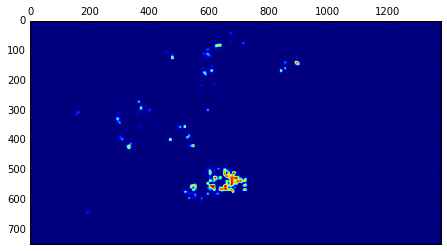

In [207]:
scoremap = score_volume_allLabels[label_dict[label]-1][..., z_level]
plt.matshow(scoremap);

In [208]:
# def score_transform(tx, ty, theta, sc, scoremap, init_cnt):
def score_transform_affine(tx, ty, theta, scx, scy, a, b, init_cnt):
    
    xmin, ymin = np.min(init_cnt, axis=0)
    xmax, ymax = np.max(init_cnt, axis=0)
    cx, cy = np.mean(init_cnt, axis=0)
    center = np.array([cx, cy])

    xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
    pts = np.c_[xs.flat, ys.flat]
    nzs = pts[np.where(Path(init_cnt).contains_points(pts))[0]]
        
    cos_z = np.cos(theta)
    sin_z = np.sin(theta)
    R = np.array([[scx*cos_z, -scx*sin_z], [scy*sin_z, scy*cos_z]])
    
    test_xs, test_ys = (np.dot(np.dot([[1, a], [b, 1]], R), nzs.T - np.array([cx,cy])[:,np.newaxis]) + \
                        np.array([tx+cx,ty+cy])[:,np.newaxis]).astype(np.int)

    valid = (test_xs >= 0) & (test_ys >= 0) & \
            (test_xs < scoremap.shape[1]) & (test_ys < scoremap.shape[0])
    
    score = scoremap[test_ys[valid], test_xs[valid]].sum() * scx * scy

    return score

In [209]:
from joblib import Parallel, delayed

In [210]:
def grid_search_affine(init_cnt, init_params=(0,0,0,1), iter_num=100, 
                       sigma_tx0=100, sigma_ty0=100, sigma_theta_z0=30, sigma_scx0=0.2, sigma_scy0=0.2,
                      sigma_a0=.5, sigma_b0=.5):
    
    params_best_upToNow = init_params
    score_best_upToNow = 0

    for iteration in range(iter_num):

        print iteration

        init_tx, init_ty, init_theta_z, init_scalex, init_scaley, init_a, init_b = params_best_upToNow

        # tx_grid = np.linspace(init_tx-400,init_tx+400,10)
        # ty_grid = np.linspace(init_ty-400,init_ty+400,10)
        # tz_grid = np.linspace(init_tz-200,init_tz+200,10)
        # theta_z_grid = np.deg2rad(np.linspace(init_theta_z-20,init_theta_z+20,5))
        # theta_y_grid = np.deg2rad(np.linspace(init_theta_y-20,init_theta_y+20,5))

        n = int(1000*np.exp(-iteration/10.))
        if n < 10:
            break

        # tx_grid = np.random.randint(init_tx-400, init_tx+400, n)
        # ty_grid = np.random.randint(init_ty-400, init_ty+400, n)
        # tz_grid = np.random.randint(init_tz-200, init_tz+200, n)
        # theta_z_grid = np.deg2rad(np.random.randint(-20, 20, n))
        # theta_y_grid = np.deg2rad(np.random.randint(-20, 20, n))

        sigma_tx = sigma_tx0*np.exp(-iteration/3.)
        sigma_ty = sigma_ty0*np.exp(-iteration/3.)
        sigma_theta_z = np.deg2rad(sigma_theta_z0*np.exp(-iteration/.6))
        sigma_scx = sigma_scx0*np.exp(-iteration/20.)
        sigma_scy = sigma_scy0*np.exp(-iteration/20.)
        sigma_a = sigma_a0*np.exp(-iteration/5.)
        sigma_b = sigma_b0*np.exp(-iteration/5.)

        print sigma_tx, sigma_ty, sigma_theta_z, sigma_scx, sigma_scy
        
    #     tx_grid = sigma_tx * np.random.randn(n) + init_tx
    #     ty_grid = sigma_ty * np.random.randn(n) + init_ty
    #     tz_grid = sigma_tz * np.random.randn(n) + init_tz
    #     theta_z_grid = sigma_theta_z * np.random.randn(n) + init_theta_z
    #     theta_y_grid = sigma_theta_y * np.random.randn(n) + init_theta_y
    
        tx_grid = init_tx + 2*sigma_tx*np.random.random(n) - sigma_tx
        ty_grid = init_ty + 2*sigma_ty*np.random.random(n) - sigma_ty
        theta_z_grid = init_theta_z + 2*sigma_theta_z*np.random.random(n) - sigma_theta_z
        scalex_grid = init_scalex * np.exp(2*sigma_scx*np.random.random(n) - sigma_scx)
        scaley_grid = init_scaley * np.exp(2*sigma_scy*np.random.random(n) - sigma_scy)
        a_grid = init_a + 2*sigma_a*np.random.random(n) - sigma_a
        b_grid = init_b + 2*sigma_b*np.random.random(n) - sigma_b
        

        scores = Parallel(n_jobs=16)(delayed(score_transform_affine)(tx, ty, theta_z, scx, scy, a, b, init_cnt) 
                                     for tx, ty, theta_z, scx, scy, a, b in zip(tx_grid, ty_grid, theta_z_grid,
                                                               scalex_grid, scaley_grid, a_grid, b_grid))

        score_best = np.max(scores)

        tx_best, ty_best, theta_z_best, scalex_best, scaley_best, a_best, b_best = \
            zip(tx_grid, ty_grid, theta_z_grid, scalex_grid, scaley_grid, a_grid, b_grid)[np.argmax(scores)]
            
        
        scalex_best = min(2., max(scalex_best, 0.1))
        scaley_best = min(2., max(scaley_best, 0.1))
            
            
        if score_best > score_best_upToNow:
            print score_best_upToNow, score_best

            score_best_upToNow = score_best
            params_best_upToNow = tx_best, ty_best, theta_z_best, scalex_best, scaley_best, a_best, b_best

            print tx_best, ty_best, np.rad2deg(theta_z_best), scalex_best, scaley_best, a_best, b_best
            
    return params_best_upToNow

In [211]:
def optimal_params_slice_affine(init_cnt, scoremap, init_params=(0,0,0,1,1,0,0), 
                                iter_num=100, return_scores=False, lr=(.1,0,1e-6,0)):
    
    lr1, lr2, lr3, lr4 = lr
    
    score_best = 0
    
    xmin, ymin = np.min(init_cnt, axis=0)
    xmax, ymax = np.max(init_cnt, axis=0)
    cx, cy = np.mean(init_cnt, axis=0)
    
    xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
    pts = np.c_[xs.flat, ys.flat]
    nzs = pts[np.where(Path(init_cnt).contains_points(pts))[0]].T

    dSdxyz = np.gradient(scoremap, 3, 3)

    scores = []

    tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best  = init_params

    for iteration in range(iter_num):

        dMdu = 0
        dMdv = 0
        dMdaz = 0
        dMdsx = 0
        dMdsy = 0
        dMda = 0
        dMdb = 0

        cos_z = np.cos(theta_best)
        sin_z = np.sin(theta_best)
        Rz_best = np.array([[sx_best*cos_z, -sx_best*sin_z], 
                            [sy_best*sin_z, sy_best*cos_z]])
        
        t = np.array([tx_best, ty_best])
        center = np.array([cx, cy])
        ds = nzs - center[:, np.newaxis]
                
        xs_prime, ys_prime = (np.dot([[1, a_best],[b_best, 1]], np.dot(Rz_best, ds)) + (t + center)[:,np.newaxis]).astype(np.int)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & \
                (xs_prime < scoremap.shape[1]) & (ys_prime < scoremap.shape[0])

        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            
            dxs, dys = ds
            dxs_valid = dxs[valid]
            dys_valid = dys[valid]

            xs, ys = nzs
            xs_valid = xs[valid]
            ys_valid = ys[valid]

            Sx = dSdxyz[1][ys_prime_valid, xs_prime_valid]
            Sy = dSdxyz[0][ys_prime_valid, xs_prime_valid]
            S = scoremap[ys_prime_valid, xs_prime_valid].sum()
            
#             fxx = sx_best*cos_z + a_best*sy_best*sin_z
#             fxy = -sx_best*sin_z + a_best*sy_best*cos_z
#             fyx = b_best*sx_best*cos_z + sy_best*sin_z
#             fyy = -b_best*sin_z*sx_best + sy_best*cos_z
            
#             dMdu += (np.dot(Sx, (-fxx+1)*dxs_valid) + np.dot(Sy, (-fyx+1)*dys_valid)) * sx_best * sy_best
#             dMdv += (np.dot(Sx, (-fxy+1)*dxs_valid) + np.dot(Sy, (-fyy+1)*dys_valid)) * sx_best * sy_best
            
            dMdu += Sx.sum() * sx_best * sy_best
            dMdv += Sy.sum() * sx_best * sy_best
            
            dx2dsx = dxs_valid*cos_z - dys_valid*sin_z
            dx2dsy = dxs_valid*a_best*sin_z + dys_valid*a_best*cos_z
            
            dy2dsx = dxs_valid*b_best*cos_z + dys_valid*(-b_best*sin_z)
            dy2dsy = dxs_valid*sin_z + dys_valid*cos_z
            
            dMdsx += ((np.dot(Sx, dx2dsx) + np.dot(Sy, dy2dsx)) * sx_best + .1*S) * sy_best
            dMdsy += ((np.dot(Sx, dx2dsy) + np.dot(Sy, dy2dsy)) * sy_best + .1*S) * sx_best
            

            dx2dtheta = dxs_valid*(-sx_best*sin_z+a_best*sy_best*cos_z) + \
                        dys_valid*(-sx_best*cos_z-a_best*sy_best*sin_z)
        
            dy2dtheta = dxs_valid*(-b_best*sin_z*sx_best+sy_best*cos_z) + \
                        dys_valid*(-b_best*sx_best*cos_z-sy_best*sin_z)

            dMdaz += (np.dot(Sx, dx2dtheta) + np.dot(Sy, dy2dtheta)) * sy_best * sx_best

#             dMdsx += np.dot(dSdxyz[1][ys_prime_valid, xs_prime_valid],
#                             (cos_z-b_best*sin_z)*xs_valid + (-a_best*cos_z-sin_z)*ys_valid) * scx_best * scy_best + \
#                     .5*scoremap[ys_prime_valid, xs_prime_valid].sum() * scy_best

#             dMdsy += np.dot(dSdxyz[0][ys_prime_valid, xs_prime_valid],
#                             (sin_z+b_best*cos_z)*xs_valid + (a_best*sin_z+cos_z)*ys_valid) * scx_best * scy_best + \
#                     .1*scoremap[ys_prime_valid, xs_prime_valid].sum() * scx_best
                
#             dMda += (np.dot(dSdxyz[1][ys_prime_valid, xs_prime_valid], -sin_z*sc_best*ys_valid) + \
#                     np.dot(dSdxyz[0][ys_prime_valid, xs_prime_valid], cos_z*sc_best*ys_valid)) * sc_best
                
#             dMdb += (np.dot(dSdxyz[1][ys_prime_valid, xs_prime_valid], -cos_z*sc_best*xs_valid) + \
#                     np.dot(dSdxyz[0][ys_prime_valid, xs_prime_valid], -sin_z*sc_best*xs_valid)) * sc_best

        print '(dMdu, dMdv):', dMdu, dMdv
        print '(dMdaz):', dMdaz
        print '(dMdsx, dMdsy):', dMdsx, dMdsy
        print '(dMda, dMdb):', dMda, dMdb

        print 'lr1:', lr1, ', lr2:', lr2, ', lr3:', lr3, ', lr4:', lr4

#         lr1 = lr[0]*np.exp(-iteration/30.)
        
#         lr3 = lr[2]*np.exp(-iteration/30.)
        
        tx_best += lr1*dMdu
        ty_best += lr1*dMdv
        theta_best += lr2*dMdaz

        theta_best = theta_best%(2*np.pi)
        if theta_best > np.pi:
            theta_best -= 2*np.pi
        elif theta_best < -np.pi:
            theta_best += 2*np.pi
            
        sx_best += lr3*dMdsx
        sy_best += lr3*dMdsy
        
        sx_best = min(2., max(sx_best, 0.1))
        sy_best = min(2., max(sy_best, 0.1))
        
        a_best += lr4*dMda
        b_best += lr4*dMdb
    
        print '(tx_best, ty_best):', tx_best, ty_best
        print '(theta_best):', theta_best
        print '(theta_best) in degrees:', np.rad2deg(theta_best)
        print '(scx_best, scy_best):', sx_best, sy_best
        print '(a, b):', a_best, b_best

        s = scoremap[ys_prime_valid, xs_prime_valid].sum() * sx_best * sy_best
#         s = scoremap[ys_prime_valid, xs_prime_valid].sum()

        print 'score:', s
        scores.append(s)

        print '\n'
        
        params_best_upToNow = (tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best)

#         if s > score_best:
#             print 'Current best'
#             params_best_upToNow = (tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best)
#             score_best = s
        
    best_finetune_params = params_best_upToNow
    
    if return_scores:
        return best_finetune_params, scores
    else:
        return best_finetune_params

In [218]:
# params_grid_search = grid_search(init_cnt, iter_num=10, init_params=(0, 0, 0, 1.),
#                                 sigma_tx0=100, sigma_ty0=100, sigma_theta_z0=0.01, sigma_sc0=.5)

params_grid_search = grid_search_affine(init_cnt, iter_num=10, init_params=(0, 0, 0, 2., 2, 0, 0),
                                sigma_tx0=300, sigma_ty0=300, sigma_theta_z0=0, 
                                        sigma_scx0=0, sigma_scy0=0,
                                        sigma_a0=0, sigma_b0=0)
                                 
print params_grid_search

0
300.0 300.0 0.0 0.0 0.0
0 2014.56747147
30.0376403507 -2.18104507539 0.0 2.0 2.0 0.0 0.0
1
214.959393172 214.959393172 0.0 0.0 0.0
2014.56747147 2030.39866049
81.4558658386 -13.0422575082 0.0 2.0 2.0 0.0 0.0
2
154.02513571 154.02513571 0.0 0.0 0.0
2030.39866049 2079.69862149
37.4718825368 -3.14471271589 0.0 2.0 2.0 0.0 0.0
3
110.363832351 110.363832351 0.0 0.0 0.0
4
79.0791414347 79.0791414347 0.0 0.0 0.0
5
56.6626808513 56.6626808513 0.0 0.0 0.0
2079.69862149 2103.83846078
38.6688994179 -5.32848828169 0.0 2.0 2.0 0.0 0.0
6
40.600584971 40.600584971 0.0 0.0 0.0
7
29.0915903593 29.0915903593 0.0 0.0 0.0
8
20.8450353668 20.8450353668 0.0 0.0 0.0
9
14.9361205104 14.9361205104 0.0 0.0 0.0
(38.668899417851478, -5.3284882816881449, 0.0, 2.0, 2.0, 0.0, 0.0)


In [219]:
best_finetune_params, scores = optimal_params_slice_affine(init_cnt, scoremap, init_params=params_grid_search,
                                                           iter_num=5000, return_scores=True, lr=(1e-2,1e-6,1e-6,0))

# best_finetune_params, scores = optimal_params_slice_affine(init_cnt, scoremap, init_params=(0, 0,0,1,1,0,0),
#                                                            iter_num=3000, return_scores=True, lr=(1e-2,1e-6,0,0))

# best_finetune_params, scores = optimal_params_slice_affine(init_cnt, scoremap, init_params=(0,0,0,1,1,0,0),
#                                                            iter_num=2000, return_scores=True, lr=(.1,1e-6,1e-7,0))

(dMdu, dMdv): 0.32919113956 0.610802789339
(dMdaz): 170.074539445
(dMdsx, dMdsy): -106.90410383 -55.7553049883
(dMda, dMdb): 0 0
lr1: 0.01 , lr2: 1e-06 , lr3: 1e-06 , lr4: 0
(tx_best, ty_best): 38.6721913292 -5.32238025379
(theta_best): 0.000170074539445
(theta_best) in degrees: 0.00974455331283
(scx_best, scy_best): 1.9998930959 1.9999442447
(a, b): 0.0 0.0
score: 2103.66735936


(dMdu, dMdv): 0.329164367033 0.610753113839
(dMdaz): 170.183916526
(dMdsx, dMdsy): -106.893367248 -55.729790964
(dMda, dMdb): 0 0
lr1: 0.01 , lr2: 1e-06 , lr3: 1e-06 , lr4: 0
(tx_best, ty_best): 38.6754829729 -5.31627272266
(theta_best): 0.000340258455971
(theta_best) in degrees: 0.0194953734708
(scx_best, scy_best): 1.99978620253 1.9998885149
(a, b): 0.0 0.0
score: 2103.49630233


(dMdu, dMdv): 0.329137601452 0.610703451229
(dMdaz): 170.293345536
(dMdsx, dMdsy): -106.88262938 -55.7042664424
(dMda, dMdb): 0 0
lr1: 0.01 , lr2: 1e-06 , lr3: 1e-06 , lr4: 0
(tx_best, ty_best): 38.6787743489 -5.31016568814
(theta_

In [220]:
print best_finetune_params

(34.763417612081426, -3.2207650631783089, 0.056354057494419747, 1.8054024156990469, 1.7238027617693843, 0.0, 0.0)


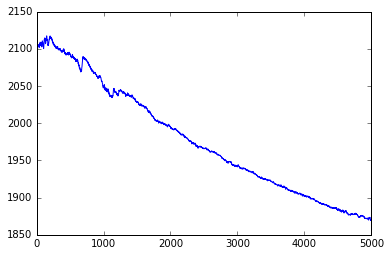

In [221]:
plt.plot(scores);

34.7634176121 -3.22076506318 3.22884965287 1.8054024157 1.72380276177 0.0 0.0


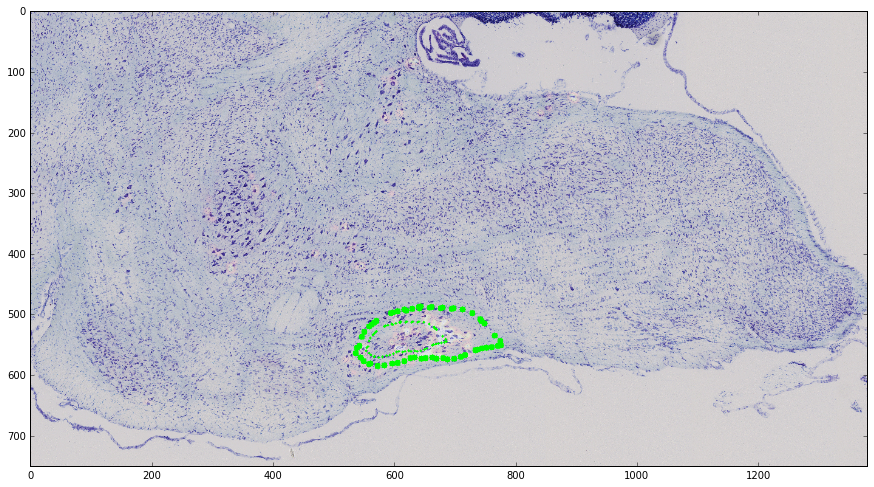

In [222]:
viz1 = cropped_img
viz2 = plt.cm.hot(scoremap)
viz = img_as_ubyte(alpha_blending(viz1, viz2[...,:3], .9, 1.))

for pt in init_cnt:
    cv2.circle(viz, tuple(pt), 2, (0,255,0,255), -1)

tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best = best_finetune_params
print tx_best, ty_best, np.rad2deg(theta_best), sx_best, sy_best, a_best, b_best

# tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best = (100,0,0,2.,1,0,0)
# sx_best = 2

xmin, ymin = np.min(init_cnt, axis=0)
xmax, ymax = np.max(init_cnt, axis=0)
cx, cy = np.mean(init_cnt, axis=0)

center = np.array([cx, cy])

xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
pts = np.c_[xs.flat, ys.flat]
nzs = pts[np.where(Path(init_cnt).contains_points(pts))[0]].T

cos_z = np.cos(theta_best)
sin_z = np.sin(theta_best)
R = np.array([[sx_best*cos_z, -sx_best*sin_z], 
              [sy_best*sin_z, sy_best*cos_z]])

t = np.array([tx_best, ty_best])

xs, ys = (np.dot(np.dot([[1, a_best], [b_best, 1]], R), 
                 init_cnt.T - center[:, np.newaxis]) + (t+center)[:, np.newaxis]).astype(np.int)

valid = (xs >= 0) & (ys >= 0) & (xs < scoremap.shape[1]) & (ys < scoremap.shape[0])

new_cnt = np.c_[xs, ys][valid]

for xy in new_cnt:
    cv2.circle(viz, tuple(xy), 5, (0, 255, 0, 255), -1)

plt.figure(figsize=(15,15));
# plt.title('section = %d, z = %.2f'%(map_z_to_section[z_level], z_level))
plt.imshow(viz);
plt.show();

In [204]:
init_cnt_allLandmarks[label] = init_cnt
new_cnt_allLandmarks[label] = new_cnt

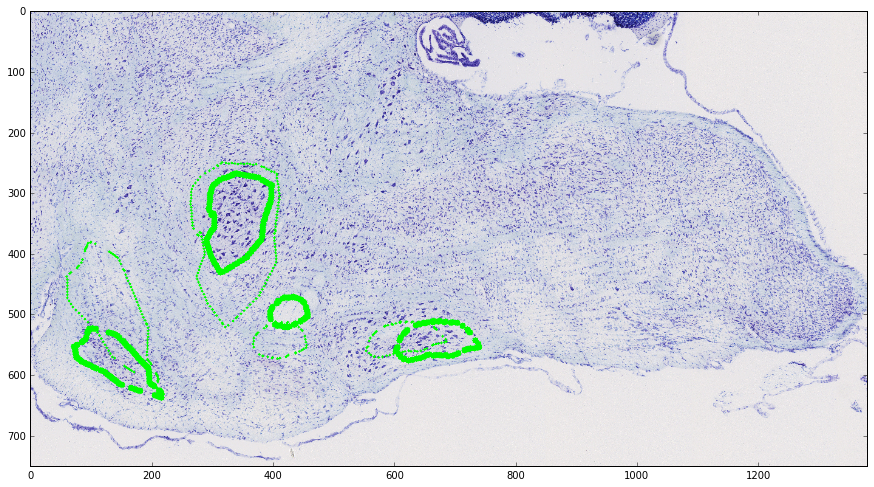

In [224]:
viz = cropped_img.copy()

for label, cnt in init_cnt_allLandmarks.iteritems():
    for pt in cnt:
        cv2.circle(viz, tuple(pt), 2, (0,255,0,255), -1)

for label, cnt in new_cnt_allLandmarks.iteritems():
    for xy in cnt:
        cv2.circle(viz, tuple(xy), 5, (0, 255, 0, 255), -1)

plt.figure(figsize=(15,15));
# plt.title('section = %d, z = %.2f'%(map_z_to_section[z_level], z_level))
plt.imshow(viz);
plt.show();

In [225]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/cross-brain/tmp.jpg

In [16]:
downsample_factor = 8

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

stack = 'MD594'

n_sec = {'MD589': 445, 'MD594': 432}
    
# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

93 364


In [17]:
map_z_to_section = {}
for s in range(157, 167):
    for z in range(int(z_xy_ratio_downsampled*s) - 853, int(z_xy_ratio_downsampled*(s+1)) - 853+1):
        map_z_to_section[z] = s

In [18]:
s = map_z_to_section[z_level]

dm = DataManager(stack='MD594', section=s, load_mask=False)
dm._load_image(versions=['rgb-jpg'])
cropped_img = dm.image_rgb_jpg[::8, ::8][567:1316+1, 399:1778+1]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (167180288 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
